In [1]:
from UniDec import unidec
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import numpy as np
from ctypes import *
import sys
import os
import baf2sql

In [2]:
analysis_dir = "example_analysis.d"

# --- data extraction using baf2sql DLL 

if sys.version_info.major == 2:
    # note: assuming a european Windows here...
    analysis_dir = unicode(analysis_dir, 'cp1252')
    
baf_fn = os.path.join(analysis_dir, "analysis.baf")
sqlite_fn = baf2sql.getSQLiteCacheFilename(baf_fn)
conn = sqlite3.connect(sqlite_fn)

# --- Count spectra
q = conn.execute("SELECT COUNT(*) FROM Spectra "
                 "WHERE LineMzId NOT NULL AND ProfileMzId NOT NULL")
row = q.fetchone()
N = row[0]
print("Specified BAF has {} spectra with line and profile data.".format(N))

# --- Plot TIC and BPC over MS^1 spectra
q = conn.execute("SELECT Rt, SumIntensity, MaxIntensity FROM Spectra s "
                 "JOIN AcquisitionKeys ak ON s.AcquisitionKey = ak.Id "
                 "WHERE ak.MsLevel = 0 "
                 "ORDER BY s.ROWID")
data = [ row for row in q ]
rt = [ row[0] for row in data ]
tic = [ row[1] for row in data ]
bpc = [ row[2] for row in data ]

# plt.figure()
# plt.plot(rt, tic)
# # plt.hold(True)
# plt.plot(rt, bpc, '--')
# plt.xlabel('retention time / s')
# plt.ylabel('intensity / a.u.')
# plt.legend(['TIC', 'BPC'])
# plt.show()


# --- Plot mean spectrum within time window

np_bpc = np.array(bpc, dtype = 'float')

# get time window around base-peak intensity 
rt_range = rt[np.nanargmax(np_bpc) - 5: np.nanargmax(np_bpc) + 6]

spec_vals = {'profile_mz':[], 'profile_int':[], 'line_mz':[], 'line_int':[]}

for i in rt_range: 

    q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                    "WHERE ABS(Rt - {}) < 1e-8".format(i))
                
    row = q.fetchone()

    bs = baf2sql.BinaryStorage(baf_fn)

    if not all(row) == False: # check for None values

        bs = baf2sql.BinaryStorage(baf_fn)

        profile_mz = bs.readArrayDouble(row[2])
        profile_int = bs.readArrayDouble(row[3])

        spec_vals['profile_mz'].append(profile_mz)
        spec_vals['profile_int'].append(profile_int)


        line_mz = bs.readArrayDouble(row[0])
        line_int = bs.readArrayDouble(row[1])

        # stem() can take quite some time, so we reduce data for this example:

        max_points = 100;

        if len(line_mz) > max_points:
            line_mz = line_mz[0:max_points]
            line_int = line_int[0:max_points]
        
        spec_vals['line_mz'].append(line_mz)
        spec_vals['line_int'].append(line_int)




Specified BAF has 159 spectra with line and profile data.


In [11]:
# --- plot mean data within a time window 

# convert resulting spectra values into arrays
np_profile_mz = np.array(spec_vals['profile_mz'])
np_profile_int = np.array(spec_vals['profile_int'])

# np_line_mz = np.array(spec_vals['line_mz'])
# np_line_int = np.array(spec_vals['line_int'])

# take average of arrays 
mean_profile_mz = np.average(np_profile_mz, axis = 0)
mean_profile_int = np.average(np_profile_int, axis = 0)
# mean_line_mz = np.average(np_profile_mz, axis = 0)
# mean_line_int = np.average(np_profile_mz, axis = 0)

# plt.figure(dpi = 120)

# # plot profile spectrum
# plt.plot(mean_profile_mz, mean_profile_int, linewidth = 0.5, color = 'red')

# # # plot line spectrum
# # plt.stem(line_mz, line_int)

# plt.xlabel("m/z / Th")
# plt.ylabel('intensity / a.u.')
# plt.title("Mean Spectrum between {}s and {}s".format(rt_range[0], rt_range[-1]))
# plt.show()

In [12]:
# --- TEMPORARY SOLUTION: make .txt file and subsequently upload into unidec engine 
# begin unidec engine here? 


mean_data = np.array([mean_profile_mz, mean_profile_int]).T
np.savetxt("mean_data2.txt", mean_data, delimiter = "\t")

In [14]:
eng = unidec.UniDec()
eng.open_file("mean_data2.txt")
# -- Data processing
eng.config.subbuff = 100 # background subtraction (subtract curved)

eng.process_data()

# -- Deconvolution
# mass range 
eng.config.massub = 13200 # upper 
eng.config.masslb = 11600 # lower
eng.config.massbins = 0.1 # sample mass ever 0.1 Da

# generate FWHM 
eng.get_auto_peak_width()

# charge range
eng.config.startz = 1
eng.config.endz = 20

# smoothing 
eng.config.zzsig = 1.0 # charge smooth width (smooth charge state distributions)
eng.config.psig = 1.0 # point smooth width (remove some artifacts)

eng.psfun = 2 # split G/L 

eng.run_unidec()


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  mean_data2.txt
Loading Time: 5.2s
Linear False
Data Prep Time: 3.1s
Automatic Peak Width: 0.03111
UniDec run 1.6s
File Name:  mean_data2.txt R Squared:  0.9765782529410972


0

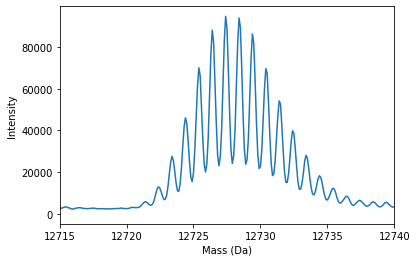

In [16]:
# check peak
mass_dist_data = np.loadtxt("mean_data1_unidecfiles/mean_data1_mass.txt")

plt.plot(mass_dist_data[:, 0], mass_dist_data[:, 1])
plt.xlim(12715, 12740)
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity')
plt.show()

In [20]:
# pick peaks and extract info
eng.pick_peaks()
eng.export_params(0)

Exported data to mean_data2_unidecfiles\mean_data2_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.20  0.28  9.13  1.58  30.74  53.62  11813.16  0.70  0.26]
 [ 12727.40  0.29  9.22  1.41  100.00  100.00  12727.41  0.60  0.33]]
Peak Parameters (Saved To mean_data2_unidecfiles\mean_data2_peakparam.dat )


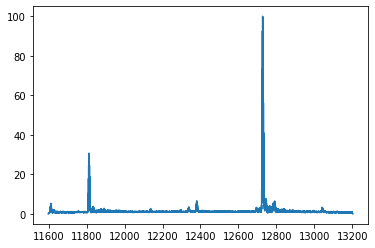

In [22]:
xvals = eng.data.massdat[:, 0]
yvals = eng.data.massdat[:, 1]

plt.plot(xvals, yvals)
plt.show()

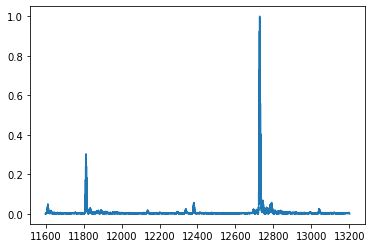

In [23]:
eng.process_mass_data()

xvals = eng.data.massdat[:, 0]
yvals = eng.data.massdat[:, 1]

plt.plot(xvals, yvals)
plt.show()

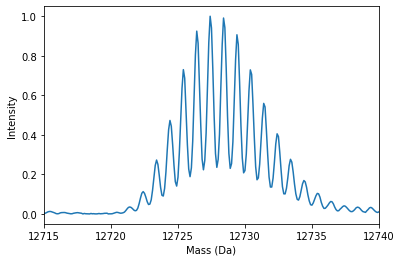

In [25]:
mass_dist_data = np.loadtxt("mean_data1_unidecfiles/mean_data1_mass.txt")

plt.plot(eng.data.massdat[:, 0], eng.data.massdat[:, 1])
plt.xlim(12715, 12740)
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity')
plt.show()

In [30]:
eng.pick_peaks()
eng.config.peaksfile

'mean_data2_unidecfiles\\mean_data2_peaks.dat'